In [1]:
import awkward as ak
import numpy as np
import hist
from coffea import processor, hist as chist
from coffea.nanoevents.methods import vector
import uproot
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.lookup_tools import extractor
import mplhep as hep
import matplotlib.pyplot as plt
import numba

In [63]:
class MyProcessor(processor.ProcessorABC):
    def process(self, events):
        #dimensions of cms and muon subdetector region
        dim = {
            'csc':{},
            'dt':{},
            'cms':{},
        }

        s = 1e2 #cm
        dim['csc']['zmin'] = s * 5.5
        dim['csc']['zmax'] = s * 10.
        dim['csc']['rmin'] = s * 0.
        dim['csc']['rmax'] = s * 7.
        dim['dt']['zmin'] = s * 0.
        dim['dt']['zmax'] = s * 6.5
        dim['dt']['rmin'] = s * 4.
        dim['dt']['rmax'] = s * 7.5
        
        dim['cms']['zmin'] = s * 0.
        dim['cms']['zmax'] = s * 12.
        dim['cms']['rmin'] = s * 0.
        dim['cms']['rmax'] = s * 8.
        
        
        dataset = events.metadata['dataset']
        sumw = ak.sum(events.genWeight)

        def R(x, y):
            return np.sqrt(x**2 + y**2)

        #makes mask of particles who's parent is an LLP
        llpPIDmomCut = (events.gParticleMotherId == 9900015)
        #takes care of multi counting by picking index of first True value in each column
        llpDaughterInd = ak.argmax(llpPIDmomCut, axis = 1, keepdims = True)
        llpMomInd = events.gParticleMotherIndex[llpDaughterInd]
        #llpMomInd = (events.gParticleId == 1000023)
        
        llps = ak.zip(
                        {
                            'X': events.gParticleProdVertexX[llpDaughterInd],
                            'Y': events.gParticleProdVertexY[llpDaughterInd],
                            'Z': events.gParticleProdVertexZ[llpDaughterInd], 
                            'R': R(events.gParticleProdVertexX[llpDaughterInd],
                                   events.gParticleProdVertexY[llpDaughterInd]),
                            'pt': ak.ones_like(events.gParticlePhi[llpMomInd]),
                            'phi': events.gParticlePhi[llpMomInd],
                            'eta': events.gParticleEta[llpMomInd],
                            'mass': ak.ones_like(events.gParticlePhi[llpMomInd]),
                        },
                        with_name = 'PtEtaPhiMLorentzVector',
                        behavior = vector.behavior,                 
                      )

        cscs = ak.zip(
                        {
                            'X': events.cscRechitClusterX,
                            'Y': events.cscRechitClusterY,
                            'Z': events.cscRechitClusterZ, 
                            'R': R(events.cscRechitClusterX, events.cscRechitClusterY),
                            'pt': ak.ones_like(events.cscRechitClusterPhi),
                            'phi': events.cscRechitClusterPhi,
                            'eta': events.cscRechitClusterEta,
                            'mass': ak.ones_like(events.cscRechitClusterPhi),
                        },
                        with_name = 'PtEtaPhiMLorentzVector',
                        behavior = vector.behavior,                 
                      )

        dts = ak.zip(
                        {
                            'X': events.dtRechitClusterX,
                            'Y': events.dtRechitClusterY,
                            'Z': events.dtRechitClusterZ, 
                            'R': R(events.dtRechitClusterX, events.dtRechitClusterY),
                            'pt': ak.ones_like(events.dtRechitClusterPhi),
                            'phi': events.dtRechitClusterPhi,
                            'eta': events.dtRechitClusterEta,
                            'mass': ak.ones_like(events.dtRechitClusterPhi),
                        },
                        with_name = 'PtEtaPhiMLorentzVector',
                        behavior = vector.behavior,                 
                      )
        
        #hist initializer
        def hister(bins, region):
            return (
                    hist.Hist.new
                    .Reg(bins, dim[region]['zmin'], dim[region]['zmax'], name = 'z', label="z decay pos [cm]")
                    .Reg(bins, dim[region]['rmin'], dim[region]['rmax'], name = 'r', label="r decay pos [cm]")
                    .Double()
                   )
        
        bins = 30
        llpDecayHist = hister(bins, region = 'cms')

        #hist filler
        def filler(hist, p):
            z = abs(ak.flatten(p.Z, axis = None))
            r = ak.flatten(p.R, axis = None)
            hist.fill(z = z, r = r)

        filler(llpDecayHist, llps)
        
        return {
            dataset: {
                "entries": len(events),
                "sumw": sumw,
                
                "llpDecayHist": llpDecayHist,
            }
        }

    def postprocess(self, accumulator):
        return accumulator

#digging up 
def rootAdds(directory):
    my_file = open(directory, "r")
    data = my_file.read().strip()
    data_into_list = data.split("\n")
    my_file.close()
    return data_into_list

In [64]:
fileset = {}
fileset['1e3mm'] = rootAdds('rootAdds/BToHNL_MuonAndHNLGenFilter_mHNL1p0_ctau1000.txt')

out = processor.run_uproot_job(
    fileset,
    treename = "ntuples/llp",
    processor_instance = MyProcessor(),
    executor = processor.futures_executor,
    executor_args = {"schema": BaseSchema, "workers": 6},
    maxchunks = 30,
)
out

Processing:   0%|          | 0/30 [00:00<?, ?chunk/s]

{'1e3mm': {'entries': 8667,
  'sumw': 8667.0,
  'llpDecayHist': Hist(
    Regular(30, 0, 1200, name='z', label='z decay pos [cm]'),
    Regular(30, 0, 800, name='r', label='r decay pos [cm]'),
    storage=Double()) # Sum: 5265.0 (8667.0 with flow)}}

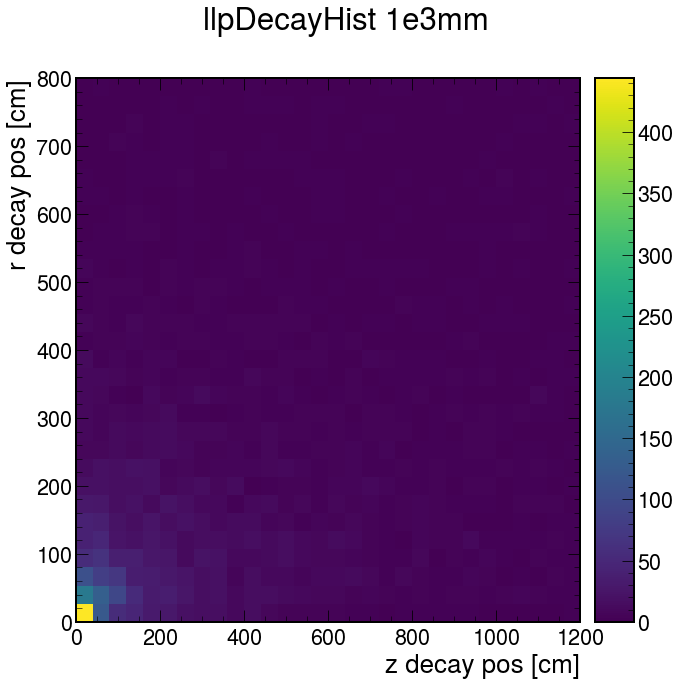

In [65]:
hep.style.use("CMS")
for junk in out:
    for jazz in out[junk]:
        if isinstance(out[junk][jazz], hist.Hist):
            fig, ax = plt.subplots()
            hep.hist2dplot(out[junk][jazz])
            fig.suptitle(f'{jazz} {junk}')

In [5]:
filename = 'root://cmsxrootd.fnal.gov//store/group/lpclonglived/displacedJetMuonNtuple/V1p17/MC_Fall18/v2/BToHNL_MuonAndHNLGenFilter_mHNL1p0_ctau1000/Run2_displacedJetMuonNtupler_V1p17_MC_Fall18_batch1_v1/220309_174743/0000/displacedJetMuon_ntupler_100.root'
file = uproot.open(filename)
events = NanoEventsFactory.from_root(
    file,
    treepath='ntuples/llp',
    entry_stop=10000,
    metadata={"dataset": "llp"},
    schemaclass=BaseSchema,
).events()

In [59]:
events.fields

['isData',
 'nPV',
 'runNum',
 'nSlimmedSecondV',
 'lumiNum',
 'eventNum',
 'eventTime',
 'pvX',
 'pvY',
 'pvZ',
 'fixedGridRhoAll',
 'fixedGridRhoFastjetAll',
 'fixedGridRhoFastjetAllCalo',
 'fixedGridRhoFastjetCentralCalo',
 'fixedGridRhoFastjetCentralChargedPileUp',
 'fixedGridRhoFastjetCentralNeutral',
 'nPVAll',
 'pvAllX',
 'pvAllY',
 'pvAllZ',
 'pvAllLogSumPtSq',
 'pvAllSumPx',
 'pvAllSumPy',
 'nBunchXing',
 'BunchXing',
 'nPU',
 'nPUmean',
 'nMuons',
 'muonE',
 'muonPt',
 'muonEta',
 'muonPhi',
 'muonCharge',
 'muonIsLoose',
 'muonIsMedium',
 'muonIsTight',
 'muon_d0',
 'muon_dZ',
 'muon_ip3d',
 'muon_ip3dSignificance',
 'muonType',
 'muonQuality',
 'muon_pileupIso',
 'muon_chargedIso',
 'muon_photonIso',
 'muon_neutralHadIso',
 'muon_ptrel',
 'muon_chargedMiniIso',
 'muon_photonAndNeutralHadronMiniIso',
 'muon_chargedPileupMiniIso',
 'muon_activityMiniIsoAnnulus',
 'muon_passSingleMuTagFilter',
 'muon_passHLTFilter',
 'muon_validFractionTrackerHits',
 'muon_isGlobal',
 'muon_no

In [62]:
pList = []
mLLP = []
for i in abs(np.unique(ak.flatten(events.gParticleId))).to_list():
    try:
        pList.append((Particle.from_pdgid(i).name,i))
    except:
        mLLP.append(i)

for ID in mLLP:
    print(np.unique(ak.flatten(events.gParticleMotherId[events.gParticleId==ID])), ID)

[] 20413
[] 5324
[5122] 4124
[] 543
[5122] 4124
[5] 5214
[-531, -521, -511, 511, 521, 531] 9900015
[21] 9940011
[21] 9941003
[21] 9942003
[21] 9942033
